In [1]:
# Importing modules
import pandas as pd
import re

# LDA Model
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import spacy
import itertools

# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

#plotting libraries!
import matplotlib.pyplot as plt
%matplotlib inline

# Import the wordcloud library
from wordcloud import WordCloud

In [2]:
movie_descrips_ratings = pd.read_csv('./ml_netflix.csv')

In [3]:
# get rid of redundancy from ratings
movies = movie_descrips_ratings.drop_duplicates('title')[['title', 'description', 'movieId']]
movies

,title,description,movieId
0,Grown Ups,Mourning the loss of their beloved junior high...,0
10,Dark Skies,A familys idyllic suburban life shatters when ...,1
12,Jaws,When an insatiable great white shark terrorize...,2
103,Jaws 2,Four years after the last deadly shark attacks...,3
120,Jaws: The Revenge,"After another deadly shark attack, Ellen Brody...",4
...,...,...,...
17466,Young Adult,When a divorced writer gets a letter from an o...,1051
17468,"Yours, Mine and Ours",When a father of eight and a mother of 10 prep...,1052
17470,Zodiac,"A political cartoonist, a crime reporter and a...",1053
17508,Zombieland,Looking to survive in a world taken over by zo...,1054


In [4]:
movie_descrips_ratings

,title,description,movieId,userId,rating
0,Grown Ups,Mourning the loss of their beloved junior high...,0,0,2.0
1,Grown Ups,Mourning the loss of their beloved junior high...,0,1,3.5
2,Grown Ups,Mourning the loss of their beloved junior high...,0,2,5.0
3,Grown Ups,Mourning the loss of their beloved junior high...,0,3,3.0
4,Grown Ups,Mourning the loss of their beloved junior high...,0,4,2.5
...,...,...,...,...,...
17557,Zombieland,Looking to survive in a world taken over by zo...,1054,539,3.0
17558,Zombieland,Looking to survive in a world taken over by zo...,1054,296,3.5
17559,Zombieland,Looking to survive in a world taken over by zo...,1054,95,3.0
17560,Zombieland,Looking to survive in a world taken over by zo...,1054,11,3.5


# Trying out Python LDA from [here](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) with preprocessing and K-picking from [here](https://github.com/nicoleeesim/content-based_movie_recommender)

In [5]:
# remove non-english words. Reference: https://datascience.stackexchange.com/questions/46705/to-remove-chinese-characters-as-features
movies['description'] = movies['description'].map(lambda x: re.sub("([^\x00-\x7F])+","", x))

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations and special characters

data_words = list(sent_to_words(movies['description']))

In [7]:
stop_words = stopwords.words('english')
# stop_words.extend(['']) #extend existing stop word list if needed
# print(stop_words)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [8]:
# Build the bigram 
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [9]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['mourn', 'loss', 'beloved', 'junior', 'high', 'basketball', 'coach', 'middle', 'aged', 'pal', 'joy', 'kid']]


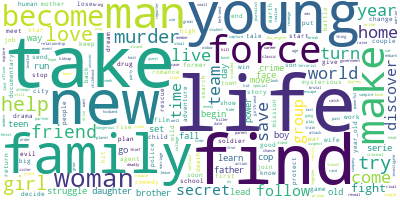

In [11]:
# Join the different processed titles together.
list_of_words = list(itertools.chain.from_iterable(data_lemmatized))
long_string = ','.join(word for word in list_of_words)
# long_string = ','.join(list(movies['descrips_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

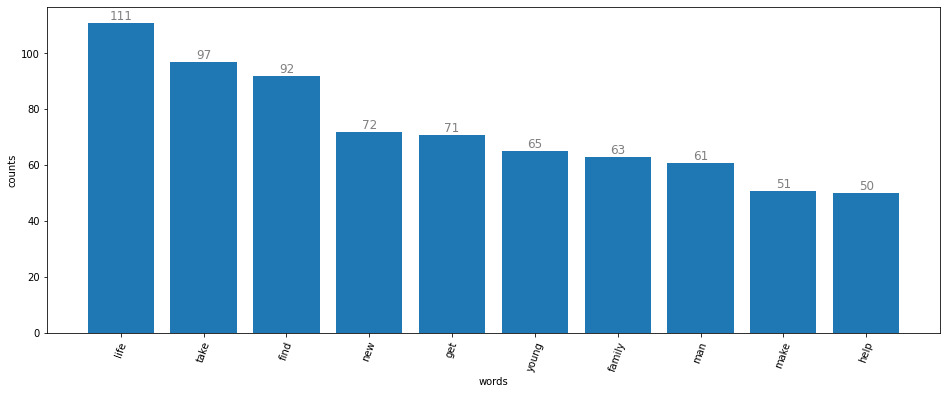

In [13]:
import operator


word_freq = []
word_list = []
count_dict = {}
for n in id2word.values():
    count_dict[n] = list_of_words.count(n)
sorted_dict = sorted(count_dict.items(), key=operator.itemgetter(1), reverse=True)[0:10]

plt.figure(figsize=(16,6))
plt.bar(range(len(sorted_dict)), [val[1] for val in sorted_dict], align='center')
plt.xticks(range(len(sorted_dict)), [val[0] for val in sorted_dict])
plt.xticks(rotation=70)
plt.xlabel('words')
plt.ylabel('counts')

# setting data labels
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='grey', ha='center', va='bottom')
    
plt.show()

## Trying out LDA with random K

In [14]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"find" + 0.011*"get" + 0.009*"plan" + 0.009*"life" + 0.008*"new" + '
  '0.007*"murder" + 0.006*"come" + 0.006*"love" + 0.005*"man" + 0.005*"world"'),
 (1,
  '0.013*"take" + 0.013*"life" + 0.010*"find" + 0.010*"win" + 0.010*"father" + '
  '0.009*"save" + 0.009*"new" + 0.008*"woman" + 0.007*"young" + '
  '0.006*"secret"'),
 (2,
  '0.013*"woman" + 0.013*"find" + 0.009*"world" + 0.009*"take" + 0.009*"day" + '
  '0.008*"make" + 0.008*"people" + 0.008*"start" + 0.007*"daughter" + '
  '0.007*"brother"'),
 (3,
  '0.012*"help" + 0.011*"fight" + 0.010*"stop" + 0.008*"get" + 0.008*"man" + '
  '0.008*"girl" + 0.008*"lose" + 0.007*"young" + 0.007*"try" + 0.007*"woman"'),
 (4,
  '0.011*"new" + 0.010*"find" + 0.010*"help" + 0.008*"old" + 0.007*"life" + '
  '0.007*"take" + 0.007*"modern" + 0.006*"force" + 0.006*"wife" + '
  '0.006*"friend"'),
 (5,
  '0.013*"family" + 0.011*"life" + 0.009*"adventure" + 0.008*"decide" + '
  '0.008*"young" + 0.008*"tale" + 0.008*"find" + 0.008*"time" + 0.00

In [16]:
# Evaluate base model- Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.39263595924369954


In [17]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [18]:
# Iterate over possible number of topics. takes about 2-3mins
topic_param = [1,5,10,15,20,25,30,35,40]
coherence_score = []

for k in topic_param:
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(cv)

param_tuning_coherence = pd.DataFrame()
param_tuning_coherence["topic_param"] = topic_param
param_tuning_coherence['coherence_score'] = coherence_score
param_tuning_coherence

,topic_param,coherence_score
0,1,0.382000
1,5,0.383452
2,10,0.390016
3,15,0.389755
4,20,0.389700
5,25,0.393063
6,30,0.382363
7,35,0.394417
8,40,0.407104


In [34]:
# num_topics = param_tuning_coherence.iloc[param_tuning_coherence['coherence_score'].idxmax()]['topic_param']
num_topics = 25

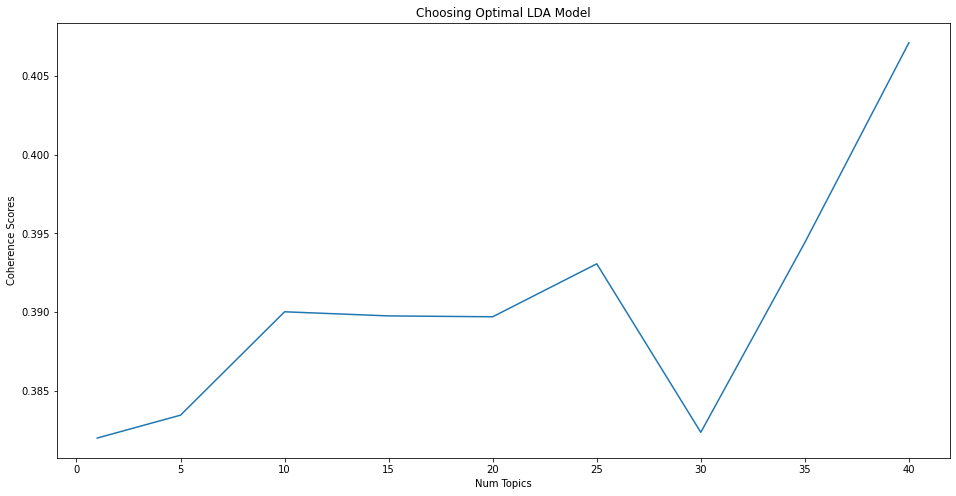

In [35]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, param_tuning_coherence['coherence_score'])

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

In [36]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [37]:
# Print the Keyword in the num_topics topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(7,
  '0.024*"force" + 0.020*"take" + 0.016*"girl" + 0.013*"new" + 0.012*"family" '
  '+ 0.012*"partner" + 0.011*"find" + 0.011*"become" + 0.010*"get" + '
  '0.010*"dream"'),
 (1,
  '0.016*"find" + 0.013*"become" + 0.010*"love" + 0.009*"comedy" + 0.009*"new" '
  '+ 0.009*"woman" + 0.008*"take" + 0.008*"depression" + 0.008*"accident" + '
  '0.008*"engage"'),
 (17,
  '0.021*"death" + 0.017*"fight" + 0.015*"criminal" + 0.015*"fall" + '
  '0.014*"man" + 0.012*"discover" + 0.011*"save" + 0.011*"find" + 0.011*"help" '
  '+ 0.010*"come"'),
 (24,
  '0.020*"life" + 0.019*"drug" + 0.018*"mother" + 0.017*"help" + 0.011*"new" + '
  '0.011*"city" + 0.010*"try" + 0.009*"turn" + 0.009*"family" + '
  '0.008*"murder"'),
 (20,
  '0.017*"make" + 0.013*"true" + 0.013*"win" + 0.010*"journey" + 0.010*"new" + '
  '0.010*"take" + 0.010*"mar" + 0.010*"crime" + 0.010*"event" + 0.010*"face"'),
 (5,
  '0.018*"decide" + 0.016*"home" + 0.016*"life" + 0.014*"find" + '
  '0.014*"friend" + 0.012*"host" + 0.012*"take"

In [38]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))   

In [39]:
topic_num, prob = [], []

for n in range(len(movies)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
movies['Topic'] = topic_num
movies['Probability'] = prob
movies


,title,description,movieId,Topic,Probability
0,Grown Ups,Mourning the loss of their beloved junior high...,0,7,0.588068
10,Dark Skies,A familys idyllic suburban life shatters when ...,1,4,0.919991
12,Jaws,When an insatiable great white shark terrorize...,2,6,0.919989
103,Jaws 2,Four years after the last deadly shark attacks...,3,13,0.705347
120,Jaws: The Revenge,"After another deadly shark attack, Ellen Brody...",4,13,0.708952
...,...,...,...,...,...
17466,Young Adult,When a divorced writer gets a letter from an o...,1051,3,0.931426
17468,"Yours, Mine and Ours",When a father of eight and a mother of 10 prep...,1052,24,0.472006
17470,Zodiac,"A political cartoonist, a crime reporter and a...",1053,22,0.525363
17508,Zombieland,Looking to survive in a world taken over by zo...,1054,11,0.912725


In [40]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [41]:
# Visualize the topics
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/Users/jessicaho/Desktop/267/267env/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7      0.053415  0.025576       1        1  5.897214
24     0.046864  0.110432       2        1  5.646730
22     0.010952 -0.085800       3        1  5.257253
19    -0.077982  0.013229       4        1  4.904622
0      0.012868 -0.012279       5        1  4.519715
3     -0.027407  0.018486       6        1  4.489837
5      0.107417  0.066367       7        1  4.348852
4      0.035368  0.092052       8        1  4.299750
6      0.078873 -0.019515       9        1  4.141584
23    -0.025279 -0.123896      10        1  4.132930
1      0.008846 -0.022481      11        1  4.105150
14    -0.043627 -0.032824      12        1  4.087281
16     0.028454 -0.075126      13        1  3.914195
18     0.032877  0.039796      14        1  3.873993
20    -0.064770  0.006176      15        1  3.755420
2     -0.014945 -0.017330      16        1  3.568869
12    -0.108117 -0.014834      17        1  3.434613
11    -0.043943 -0.116214      18        1  3.433582
13     0.003141 -0.075429      19        1  3.429607
21     0.183970  0.027159      20        1  3.362790
17    -0.020966 -0.025164      21        1  3.322763
15     0.017538  0.057023      22        1  3.101554
9      0.039771 -0.041596      23        1  3.097238
10    -0.080796  0.055211      24        1  3.047148
8     -0.152523  0.150982      25        1  2.827311, topic_info=       Term       Freq      Total Category  logprob  loglift
83   murder  36.000000  36.000000  Default  30.0000  30.0000
147    help  51.000000  51.000000  Default  29.0000  29.0000
123    fall  24.000000  24.000000  Default  28.0000  28.0000
14    force  43.000000  43.000000  Default  27.0000  27.0000
315    face  24.000000  24.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
412    live   2.238976  35.133512  Topic25  -4.8831   0.8127
404  people   2.014149  17.798987  Topic25  -4.9889   1.3869
274  series   1.948298  22.681975  Topic25  -5.0221   1.1112
51      day   1.927111  25.960823  Topic25  -5.0331   0.9653
49    young   1.929805  57.257650  Topic25  -5.0317   0.1757

[1501 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
818       1  0.154054  accept
818       7  0.154054  accept
818      10  0.308108  accept
818      16  0.154054  accept
818      23  0.308108  accept
...     ...       ...     ...
49       25  0.034930   young
1582      7  0.346693  yuppie
1582     23  0.346693  yuppie
494       8  0.213961  zombie
494      18  0.641882  zombie

[4210 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 25, 23, 20, 1, 4, 6, 5, 7, 24, 2, 15, 17, 19, 21, 3, 13, 12, 14, 22, 18, 16, 10, 11, 9])

# Evaluate

In [42]:
from utils.utils import get_recs_for_all_users, get_users_faves, sort_probs, get_helper_vals, calc_personalization, mapk, mean_precision

In [43]:
movies_ratings_probs = movie_descrips_ratings.merge(movies, 'right', ['title', 'movieId'])

In [44]:
movie_descrips_ratings

,title,description,movieId,userId,rating
0,Grown Ups,Mourning the loss of their beloved junior high...,0,0,2.0
1,Grown Ups,Mourning the loss of their beloved junior high...,0,1,3.5
2,Grown Ups,Mourning the loss of their beloved junior high...,0,2,5.0
3,Grown Ups,Mourning the loss of their beloved junior high...,0,3,3.0
4,Grown Ups,Mourning the loss of their beloved junior high...,0,4,2.5
...,...,...,...,...,...
17557,Zombieland,Looking to survive in a world taken over by zo...,1054,539,3.0
17558,Zombieland,Looking to survive in a world taken over by zo...,1054,296,3.5
17559,Zombieland,Looking to survive in a world taken over by zo...,1054,95,3.0
17560,Zombieland,Looking to survive in a world taken over by zo...,1054,11,3.5


In [45]:
movies_ratings_probs

,title,description_x,movieId,userId,rating,description_y,Topic,Probability
0,Grown Ups,Mourning the loss of their beloved junior high...,0,0,2.0,Mourning the loss of their beloved junior high...,7,0.588068
1,Grown Ups,Mourning the loss of their beloved junior high...,0,1,3.5,Mourning the loss of their beloved junior high...,7,0.588068
2,Grown Ups,Mourning the loss of their beloved junior high...,0,2,5.0,Mourning the loss of their beloved junior high...,7,0.588068
3,Grown Ups,Mourning the loss of their beloved junior high...,0,3,3.0,Mourning the loss of their beloved junior high...,7,0.588068
4,Grown Ups,Mourning the loss of their beloved junior high...,0,4,2.5,Mourning the loss of their beloved junior high...,7,0.588068
...,...,...,...,...,...,...,...,...
17557,Zombieland,Looking to survive in a world taken over by zo...,1054,539,3.0,Looking to survive in a world taken over by zo...,11,0.912725
17558,Zombieland,Looking to survive in a world taken over by zo...,1054,296,3.5,Looking to survive in a world taken over by zo...,11,0.912725
17559,Zombieland,Looking to survive in a world taken over by zo...,1054,95,3.0,Looking to survive in a world taken over by zo...,11,0.912725
17560,Zombieland,Looking to survive in a world taken over by zo...,1054,11,3.5,Looking to survive in a world taken over by zo...,11,0.912725


In [46]:
# find all 4 and 5 star ratings
user_5_df, user_4_df = get_users_faves(movies_ratings_probs)

per_topic = sort_probs(int(num_topics), movies)

num_movies, num_users = get_helper_vals(movies_ratings_probs)
recommendations = get_recs_for_all_users(num_users, per_topic, user_5_df, user_4_df)

In [47]:
calc_personalization(recommendations, num_movies, num_users)
mapk(recommendations, num_users, user_5_df, user_4_df)
mean_precision(recommendations, num_users, user_5_df, user_4_df)

Personalization: 0.9475016549303051
MAP@K: 0.00010754048582995952
MEAN PRECISION (NOT mAP): 0.0022969866617006916


0.0022969866617006916

In [48]:
import ml_metrics

actuals, predicted, max_l = [], [], 0
for user in range(num_users):
    l = len(recommendations[user]) - 1
    user_actual = user_5_df[user_5_df['userId']==user]['movieId']
    if user_actual.empty:
        user_actual = user_4_df[user_4_df['userId']==user]['movieId']
    actuals.append(user_actual.to_list())
    predicted.append(recommendations[user][1:])
    if l > max_l:
        max_l = l

ml_metrics.mapk(actuals, predicted, max_l)

0.041758117585396125